## 4 Problem: Classifying Sneakers versus Sandals
### 4.1 Summarising the datasets
#### Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


#### D1 Print the number of instances

In [3]:
# Read the FMNIST training set and labels CSV file
train_labels = pd.read_csv('FMNIST_training_set_labels.csv', header=None, names=['label'])
train_set = pd.read_csv('FMNIST_training_set.csv', header=None)

# Read the FMNIST test set and labels CSV file
test_labels = pd.read_csv('FMNIST_test_set_labels.csv', header=None, names=['label'])
test_set = pd.read_csv('FMNIST_test_set.csv', header=None)

# Filter the set and labels to only include sneakers (7) and sandals (5)
ss_train_labels = train_labels[train_labels['label'].isin([5, 7])].copy()
ss_train_set = train_set[train_labels['label'].isin([5, 7])].copy()
ss_test_labels = test_labels[test_labels['label'].isin([5, 7])].copy()
ss_test_set = test_set[test_labels['label'].isin([5, 7])].copy()

# Replace the labels with 0 for sandals and 1 for sneakers
ss_train_labels['label'] = ss_train_labels['label'].replace({5: 1, 7: 0})
ss_test_labels['label'] = ss_test_labels['label'].replace({5: 1, 7: 0})

# Combined training data and testing data
ss_train = pd.concat([ss_train_labels, ss_train_set], axis=1)
ss_test = pd.concat([ss_test_labels, ss_test_set], axis=1)

# Get number of instances in the training set, test set, and total
num_train_instances = len(ss_train_set)
num_test_instances = len(ss_test_set)
num_total_instances = num_train_instances + num_test_instances

# Print the number of instances in the training set, test set, and total
print('Number of training instances:', num_train_instances)
print('Number of test instances:', num_test_instances)
print('Total number of instances:', num_total_instances)

Number of training instances: 11988
Number of test instances: 2000
Total number of instances: 13988


#### D2 Plot the number of instances per class

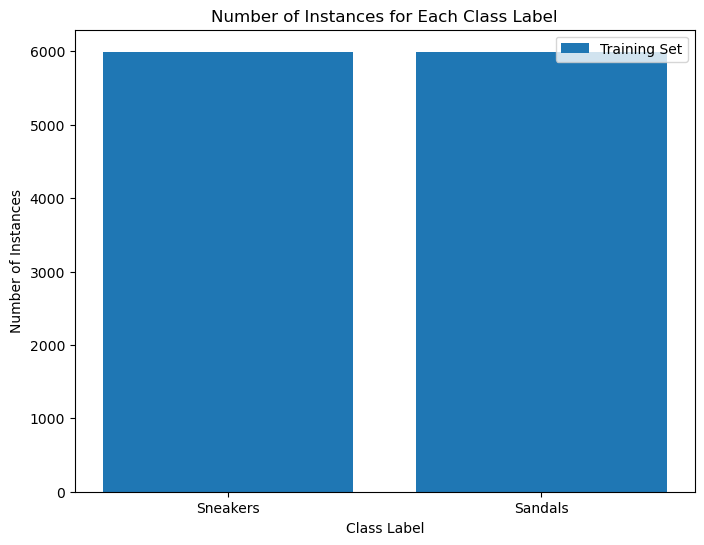

In [5]:
# Get the counts of each class label in the training set and test set
train_label_counts = ss_train['label'].value_counts()

# Plot the number of instances for each class label in the training set
plt.figure(figsize=(8, 6))
plt.bar(train_label_counts.index, train_label_counts.values, label='Training Set')
plt.xticks([0, 1], ['Sneakers', 'Sandals'])
plt.xlabel('Class Label')
plt.ylabel('Number of Instances')
plt.title('Number of Instances for Each Class Label')
plt.legend()
plt.show()

#### D3 Plot first six images from each class

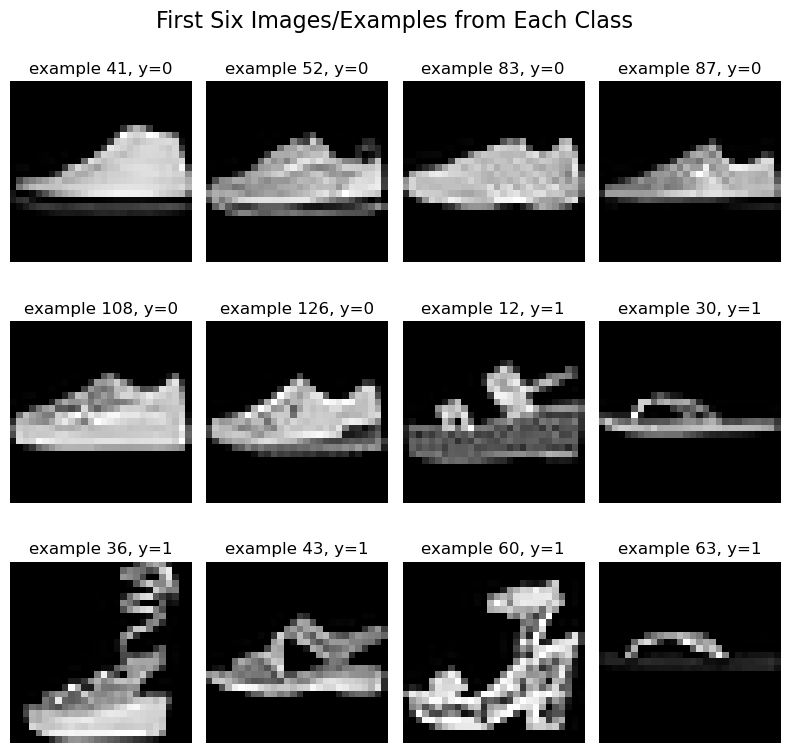

In [6]:
# First six images/examples from each class
sneakers_idx = ss_train_labels[ss_train_labels['label'] == 0].index[:6]
sandals_idx = ss_train_labels[ss_train_labels['label'] == 1].index[:6]
sneakers_images = ss_train_set.loc[sneakers_idx].values.reshape(-1, 28, 28)
sandals_image = ss_train_set.loc[sandals_idx].values.reshape(-1, 28, 28)

# Combine the images into a single array
images = np.concatenate([sneakers_images, sandals_image])
indices = np.concatenate([sneakers_idx, sandals_idx])

# Plot the first six images/examples from each class
fig, axs = plt.subplots(3, 4, figsize=(8, 8))
plt.suptitle('First Six Images/Examples from Each Class', fontsize=16)
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"example {indices[i]}, y={ss_train_labels.loc[indices[i]]['label']}")
    ax.axis('off')
plt.tight_layout()
plt.show()

### 4.2 Fitting your Logistic Regression Classifier (LRC)
#### Implementation of the LRC with Batch Gradient Descent

In [7]:
# Split the training set into training and validation sets
training_data, validation_data = train_test_split(ss_train, test_size=0.2, random_state=5508)
training_x = training_data.drop('label', axis=1)
training_y = training_data['label']
validation_x = validation_data.drop('label', axis=1)
validation_y = validation_data['label']

# Sigmoid function
def sigmoid_func(x):
    if x >= 0:
        return 1 / (1 + np.exp(-x))
    else:
        return np.exp(x) / (1 + np.exp(x))

def sigmoid(x):
    return np.array([sigmoid_func(value) for value in x])

# Loss function
def loss(theta, X, y, m):
    est_p = sigmoid(X.dot(theta))
    epsilon = 1e-5
    return -1/m * np.sum(y.dot(np.log(est_p + epsilon)) + (1-y).dot(np.log(1-est_p + epsilon)))

# Predict function
def predict(theta, X):
    h = sigmoid(np.dot(X, theta))
    y_pred = np.where(h >= 0.5, 1, 0)
    return y_pred

# Gradient Descent function
def gradient_descent(theta, X, y, learning_rate, num_iterations):
    m = len(y)
    cost_history = []
    misclass_history = []
    for i in range(num_iterations):
        est_p = sigmoid(X.dot(theta))           # compute the estimated probability for each instance
        gradients = 2/m * X.T.dot(est_p - y)    # calculate the gradient vector using all instances
        theta -= learning_rate * gradients      # update the parameter vector
        lr_cost_train = loss(theta, X, y, m)    # calculate the logistic regression cost function
        lr_cost_val = loss(theta, validation_x, validation_y, len(validation_y))
        cost_history.append((lr_cost_train, lr_cost_val))
        
        # Calculate the misclassification rate for the training and validation sets
        y_pred_train = predict(theta, X)
        y_pred_val = predict(theta, validation_x)
        misclass_rate_train = np.mean(y_pred_train != y)
        misclass_rate_val = np.mean(y_pred_val != validation_y)
        misclass_history.append((misclass_rate_train, misclass_rate_val))
    return theta, cost_history, misclass_history

#### Train the logistic regression classifier with 10000 iterations

In [8]:
# Initialize the parameters
num_iterations = 20
learning_rate = 0.01
theta = np.random.randn(training_x.shape[1])

# Train the logistic regression model
theta, cost_history, misclass_history = gradient_descent(theta, training_x, training_y, learning_rate, num_iterations)

# Calculate the accuracy of the model
y_pred = predict(theta, validation_x)
accuracy = accuracy_score(validation_y, y_pred)
print('Accuracy:', accuracy)
print('Final cost', cost_history[-1])
print('Final misclassification rate', misclass_history[-1])

Accuracy: 0.6246872393661385
Final cost (4.229880892815864, 4.318477542403271)
Final misclassification rate (0.36746611053180395, 0.37531276063386154)


#### D4 Experiment with different learning rates

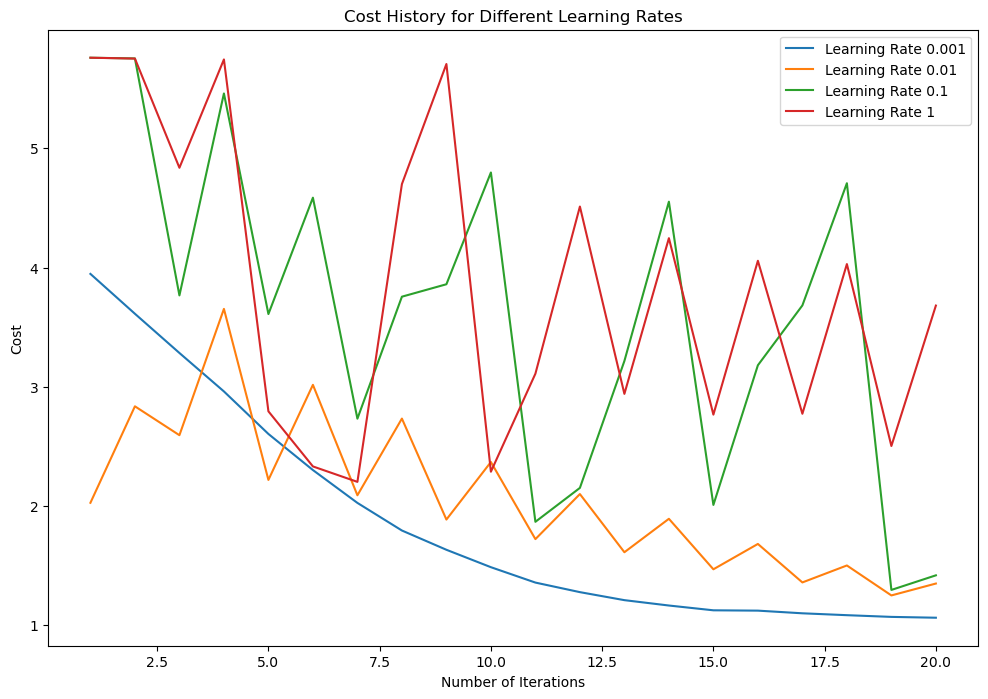

In [9]:
# Plot the cost history for the training sets using different learning rates
plt.figure(figsize=(12, 8))

learning_rates = [0.001, 0.01, 0.1, 1]
for lr in learning_rates:
    _,cost_history,_ = gradient_descent(theta.copy(), training_x, training_y, lr, num_iterations)
    cost_history_train = [cost[0] for cost in cost_history]
    plt.plot(range(1, num_iterations + 1), cost_history_train, label=f'Learning Rate {lr}')

plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.title('Cost History for Different Learning Rates')
plt.legend()
plt.show()

#### D5 Plot the cost function and the fraction of misclassifications for each iteration, using learning rate of 1e-5

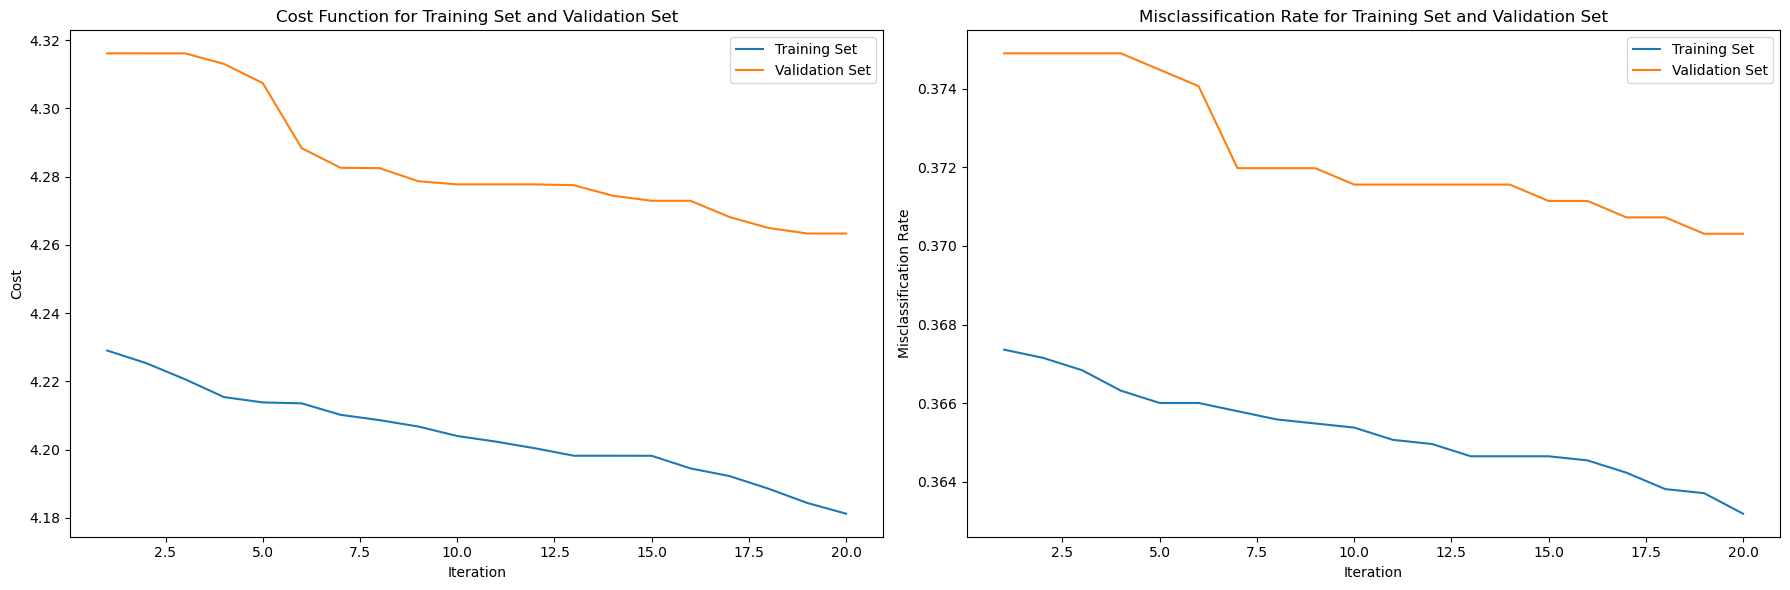

In [10]:
learning_rate = 1e-5
_, cost_history, misclass_history = gradient_descent(theta, training_x, training_y, learning_rate, num_iterations)

# Plot the cost function and misclassification rate for each iteration
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Cost function for each iteration
train_costs = [cost[0] for cost in cost_history]
val_costs = [cost[1] for cost in cost_history]
axs[0].plot(range(1, num_iterations + 1), train_costs, label='Training Set')
axs[0].plot(range(1, num_iterations + 1), val_costs, label='Validation Set')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Cost')
axs[0].set_title('Cost Function for Training Set and Validation Set')
axs[0].legend()

# Right plot: Misclassification rate for each iteration
misclass_history = np.array(misclass_history)
axs[1].plot(range(1, num_iterations + 1), misclass_history[:, 0], label='Training Set')
axs[1].plot(range(1, num_iterations + 1), misclass_history[:, 1], label='Validation Set')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Misclassification Rate')
axs[1].set_title('Misclassification Rate for Training Set and Validation Set')
axs[1].legend()

plt.tight_layout()
plt.show()

#### D6 Interpretation of the above results

### Using cross-validation and Scikit-learn LRC
#### Incorporate L2 regularisation in the LRC model

In [56]:
# Loss function with L2 regularization
def loss_l2(theta, X, y, m, C):
    est_p = sigmoid(X.dot(theta))
    epsilon = 1e-5
    reg_term = (C / (2 * m)) * np.sum(theta**2)
    return -1/m * np.sum(y.dot(np.log(est_p + epsilon)) + (1-y).dot(np.log(1-est_p + epsilon))) + reg_term

# Gradient Descent function with L2 regularization
def gradient_descent_l2(theta, X, y, learning_rate, num_iterations, C):
    m = len(y)
    cost_history = []
    misclass_history = []
    for i in range(num_iterations):
        est_p = sigmoid(X.dot(theta))
        gradients = (2/m * X.T.dot(est_p - y)) + (C / m) * theta    # 2 regularisation term
        theta -= learning_rate * gradients
        lr_cost_train = loss_l2(theta, X, y, m, C)
        lr_cost_val = loss_l2(theta, validation_x, validation_y, len(validation_y), C)
        cost_history.append((lr_cost_train, lr_cost_val))
        
        # Calculate the misclassification rate for the training and validation sets
        y_pred_train = predict(theta, X)
        y_pred_val = predict(theta, validation_x)
        misclass_rate_train = np.mean(y_pred_train != y)
        misclass_rate_val = np.mean(y_pred_val != validation_y)
        misclass_history.append((misclass_rate_train, misclass_rate_val))
    return theta, cost_history, misclass_history

#### Select the optimal regularisation parameter C

In [ ]:
num_iterations = 20
learning_rate = 0.01

C_range = np.logspace(-10, 5, 30)
best_C = None
best_cost = float('inf')
train_costs, val_costs, train_misclass, val_misclass = [], [], [], []

for C in C_range:
    _, cost_history, misclass_history = gradient_descent_l2(theta, training_x, training_y, learning_rate, num_iterations, C)
    train_costs.append(cost_history[-1][0])
    val_costs.append(cost_history[-1][1])
    train_misclass.append(misclass_history[-1][0])
    val_misclass.append(misclass_history[-1][1])
    if val_costs[-1] < best_cost:
        best_cost = val_costs[-1]
        best_C = C
        
print("Best C value:", best_C)

#### D7 Plot the cost function and the fraction of misclassification for each C value

Best C value: 0.00016102620275609426
D7


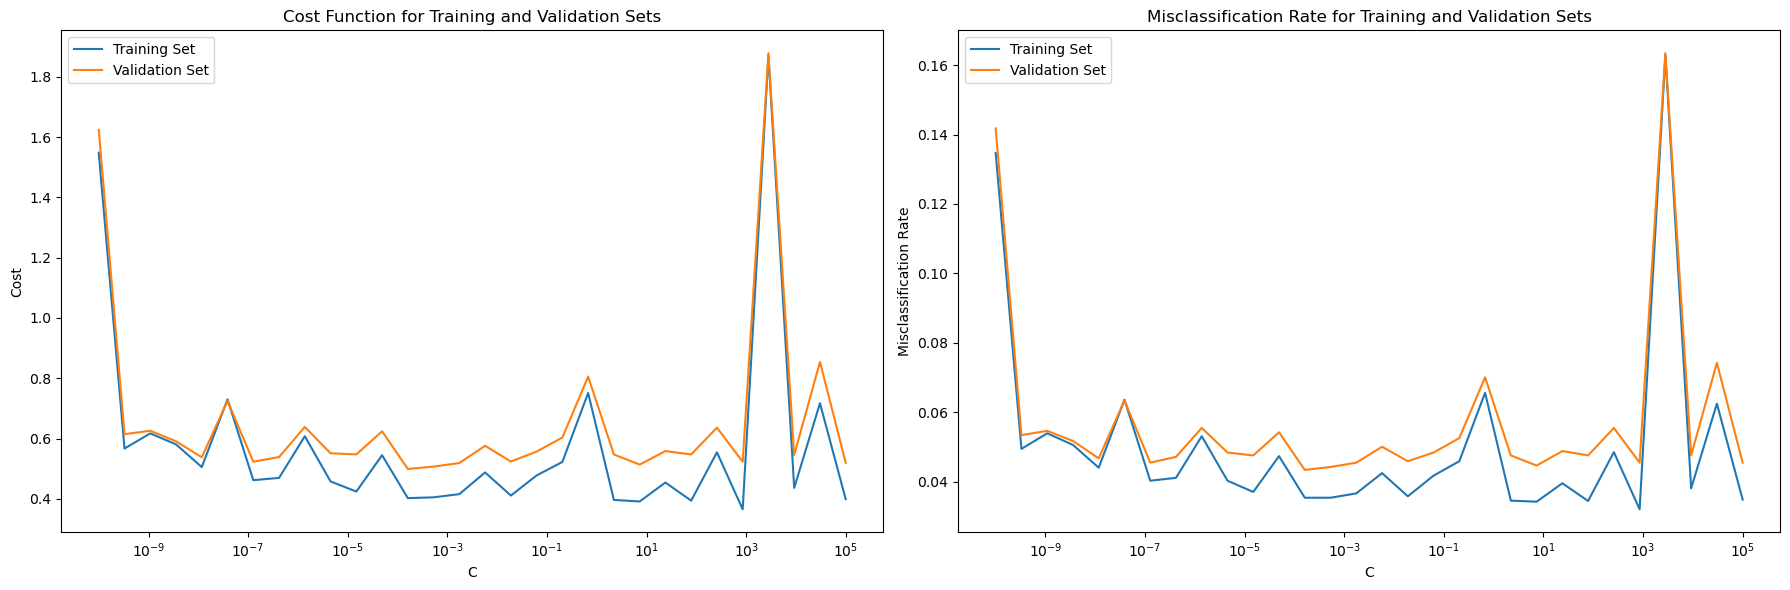

In [10]:
# Plot the cost function and misclassification rate for each C value
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Cost function for each C value
axs[0].plot(C_range, train_costs, label='Training Set')
axs[0].plot(C_range, val_costs, label='Validation Set')
axs[0].set_xscale('log')
axs[0].set_xlabel('C')
axs[0].set_ylabel('Cost')
axs[0].set_title('Cost Function for Training and Validation Sets')
axs[0].legend()

# Right plot: Misclassification rate for each C value
axs[1].plot(C_range, train_misclass, label='Training Set')
axs[1].plot(C_range, val_misclass, label='Validation Set')
axs[1].set_xscale('log')
axs[1].set_xlabel('C')
axs[1].set_ylabel('Misclassification Rate')
axs[1].set_title('Misclassification Rate for Training and Validation Sets')
axs[1].legend()

plt.tight_layout()
plt.show()

#### Using Scikit-learn LRC and GridSearchCV

In [ ]:
X, y = make_classification(n_samples=100, n_features=10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a logistic regression model
lr_model = LogisticRegression(max_iter=1000)
param_grid = {'C': C_range}

# Perform grid search with 10-fold cross-validation on the training data
# grid_search = GridSearchCV(estimator=lr_model, param_grid={'C': C_range}, cv=10, scoring='accuracy')
grid_search = GridSearchCV(lr_model, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the results
results = grid_search.cv_results_
avg_cost_values = -results['mean_test_score']
misclass_fraction = 1 - results['mean_test_score']

#### D8 Plot the average cost function and the fraction of misclassification for each C value

In [ ]:
# Plot the average cost function and misclassification rate for each C value
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Average cost function for each C value
axs[0].plot(C_range, avg_cost_values, label='Average Cost')
axs[0].set_xscale('log')
axs[0].set_xlabel('C')
axs[0].set_ylabel('Average Cost')
axs[0].set_title('Average Cost Function for Each C Value')
axs[0].legend()

# Right plot: Misclassification rate for each C value
axs[1].plot(C_range, misclass_fraction, label='Misclassification Rate')
axs[1].set_xscale('log')
axs[1].set_xlabel('C')
axs[1].set_ylabel('Misclassification Rate')
axs[1].set_title('Misclassification Rate for Each C Value')
axs[1].legend()

plt.tight_layout()
plt.show()

#### D9 Interpretation of the above results

Which regularisation hyperparameter value would you select and why?
What was the impact of using 10-fold cross-validation instead of a fixed validation set?

#### D10 Print the results according to Grid Search

In [60]:
# Get the best estimator
best_estimator = grid_search.best_estimator_
optimal_C = grid_search.best_params_['C']
theta, cost_history, misclass_history = gradient_descent_l2(theta, training_x, training_y, learning_rate, num_iterations, optimal_C)
train_cost = cost_history[-1][0]
val_cost = cost_history[-1][1]
train_misclass = misclass_history[-1][0]
val_misclass = misclass_history[-1][1]

# Print results
data = {'Optimal C': [optimal_C],
        'Training Cost Function': [train_cost],
        'Validation Cost Function': [val_cost],
        'Training Misclassifications': [train_misclass],
        'Validation Misclassifications': [val_misclass]}

df = pd.DataFrame(data).transpose()
print(df)

D10
                                       0
Optimal C                      23.950266
Training Cost Function          5.027835
Validation Cost Function       18.711889
Training Misclassifications     0.042857
Validation Misclassifications   0.050459


#### D11 Interpretation of the above results

How do they compare with what you obtain in task D8?

#### D12 Select and train the best model with the optimal C value

In [11]:
# Train the model using the optimal C value
best_lr_model = LogisticRegression(C=best_C, max_iter=1000)
best_lr_model.fit(X_train, y_train)

# Predict probabilities for the positive class (class 1) for the validation set
y_prob_val = lr_model.predict_proba(X_val)[:, 1]

# Calculate the precision and recall for different threshold values
precision, recall, thresholds = precision_recall_curve(y_val, y_prob_val)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

NameError: name 'best_C' is not defined

#### D13 Fine-tune the optimal threshold value using Grid Search

In [ ]:
# Fixed regularisation hyperparameter C
C = best_C

best_threshold = None
best_f1_score = 0

# Find the threshold that maximizes the F1 score
for threshold in thresholds:
    y_pred_val = y_prob_val >= threshold
    f1 = f1_score(y_val, y_pred_val)
    if f1 > best_f1_score:
        best_threshold = threshold
        best_f1_score = f1

print('Best threshold:', best_threshold)
print('Best F1 score:', best_f1_score)

### 4.4 Analysing the performance closer
#### D14 Print the confusion matrix, precision, recall, and false positive rate for each model
- **LR1**: The model in 4.2, which is your implementation of the logistic regression without regularisation and with a fixed validation set.
- **LR2**: The model in 4.3, which is your implementation of the logistic regression with regularisation and with a fixed validation set.
- **LR3**: The the model in 4.3 using 10-fold cross-validation and the optimal value of the regularisation hyperparameter C according to Grid Search but keeping the threshold value for the logistic regression prediction model at 0.5.
- **LR4**: The model in 4.3 using 10-fold cross-validation and the optimal value of the regularisation hyperparameter C according to Grid Search and threshold values according to your grid search in D13.

In [ ]:
# Function to calculate precision, recall, and false positive rate
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    fpr = fp / (fp + tn)
    return cm, precision, recall, fpr

# Function to evaluate each model
def evaluate_model(model, X, y, threshold=0.5):
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = y_prob >= threshold
    cm, precision, recall, fpr = calculate_metrics(y, y_pred)
    return cm, precision, recall, fpr

# Evaluate LR1, LR2, LR3, and LR4 models
models = [lr1_model, lr2_model, lr3_model, lr4_model]

for model in models:
    cm, precision, recall, fpr = evaluate_model(model, X_val, y_val, best_threshold)

    # Print the results
    print(f'Logistic Regression Model {i}:')
    print('Confusion Matrix:', cm)
    print('Precision:', precision)
    print('Recall:', recall)
    print('False Positive Rate:', fpr)
    print()

#### D15 Interpretation of the above results

Discuss generalisation capacity of the four models.

#### D16 Show 5 images that are false positives and false negatives on the test sets for model LR4

In [ ]:
# Predict probabilities for the positive class (class 1)
y_prob_test = best_lr_model.predict_proba(X_val)[:, 1]
y_pred_test = y_prob_test >= best_threshold

# Find the indices of false positives and false negatives
fp_idx = np.where((y_pred_test == 1) & (y_val == 0))[0]
fn_idx = np.where((y_pred_test == 0) & (y_val == 1))[0]

# Plot 5 false positives and 5 false negatives
fig, axs = plt.subplots(2, 5, figsize=(16, 8))

plt.show()

#### D17 Interpretation of the above results

Describe what kinds of mistakes the model is making?